<a href="https://colab.research.google.com/github/MaOdRo/master_dual_encoder/blob/main/PromptEngineering_und_SentenceTransformer_WikiClip_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Prompt Engineering


Nachdem im letzten Notebook ein multilinguales Modell erstellt und getestet wurde, dies jedoch durch die lange Trainingszeit noch nicht zur gewünschten Performanzverbesserung geführt hat, sollen im Folgenden noch zwei weitere Lösungsansätze gezeigt werden.

Radford et al. (2021) erwähnen in ihrem Paper eine weiter Methode zur Perfromanzverbesserung. Durch Prompt Engineering konnte die Performanz von Zero Shot CLIP innerhalb von 36 Datensätzen im Durchschnitt um 5 Punkte erhöht werden, wie in der unteren Abbildung zu sehen ist. Allerdings erwähnten sie, dass diese Verbesserung mit Trial und Error verbunden ist: 
"Finally, we’ve observed that CLIP’s zero-shot classifiers can be sensitive to wording or phrasing and sometimes require trial and error “prompt engineering” to perform well." S. 7

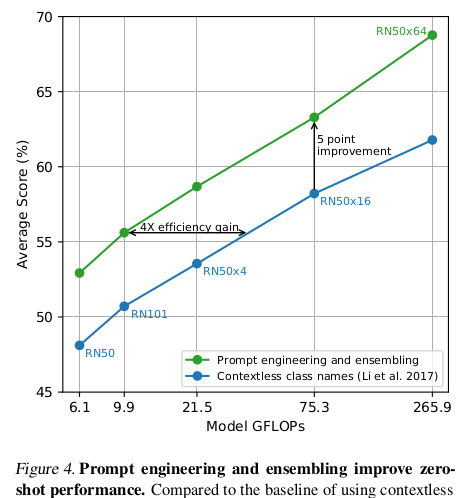

Radford et al. (2021). S. 7.

Deswegen wird das multilinguale Modell und die anderen Modelle um einen weiteren Transformer erweitert, der den Caption-Input mit einem entsprechend gewählten, übersetzten Prompt ausstattet. Es wird also ein multilinguales Prompt Engineering vorgenommen, um dann
das Ergebnis wie in den anderen Notebooks auch im Retrieval-Verfahren auf Performanzveränderungen zu untersucht. 

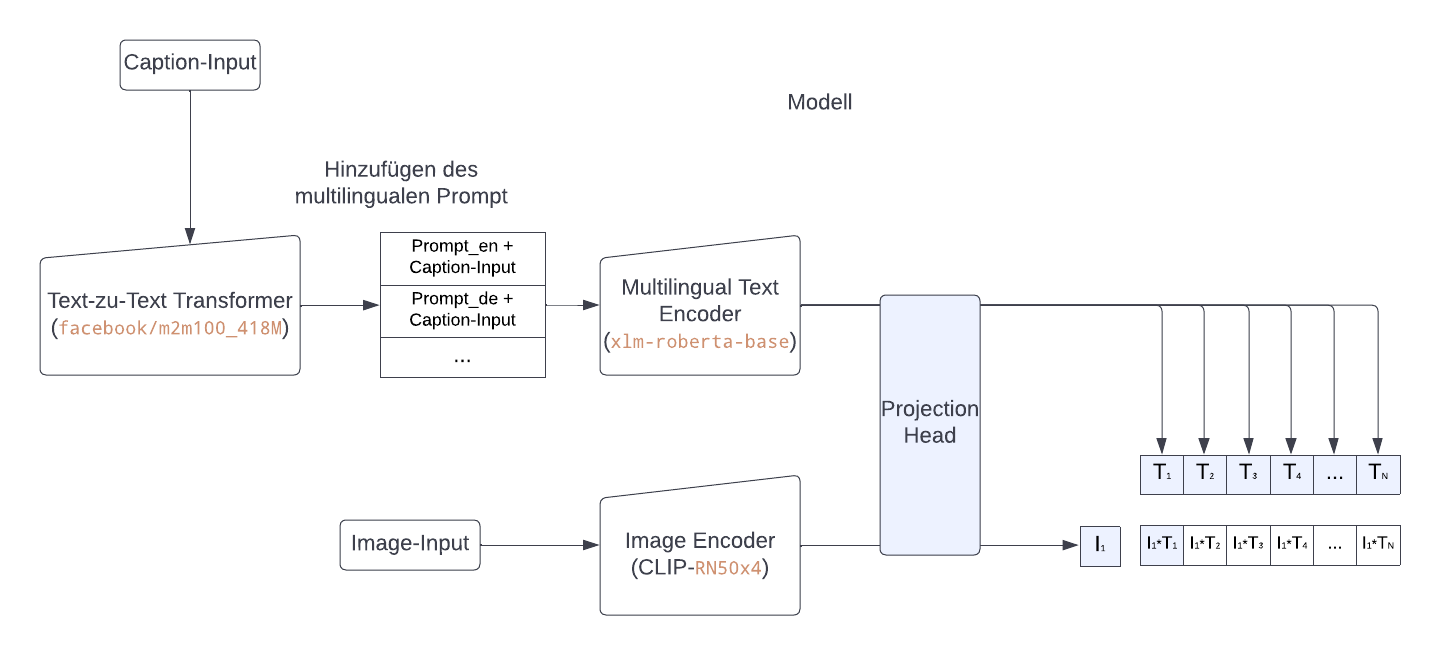

Auf einen weiteren Lösungsansatz stieß ich in der Arbeit von Reimers und Gurevych (2020). Dort wurde das Problem erwähnt, dass XLM-RoBERTa und mBERT nicht optimal beim multilingalen Zuweisen arbeiten."The issue with multilingual BERT (mBERT) as well as with XLM-RoBERTa is that those produce rather bad sentence representation out-of-the-box. Further, the vectors spaces between languages are not aligned, i.e., the sentences with the same content in different languages would be mapped to different locations in the vector space."[Quelle](https://www.sbert.net/examples/training/multilingual/README.html?highlight=sentencetransformers%20training%20code#training) Darum haben sie mit verschiedenen multilingualen Transformern innerhalb des SentenceTransformer Framework versucht dieses Poblem zu überbrücken. Die Transformer werden durch eine Student-Teacher-Architektur vortrainiert, die in der unteren Abbildung dargestellt ist. Dabei ist das Teacher-Modell monolingual und erzeugt eine Embedding für den übergebenen Input. Das Student-Modell soll dann den Input im gleichen Vektorraum - wie vom Teacher-Modell vorgegeben - erzeugen. Das wird durch das Training mit dem Mean Square Error (MSE) erreicht.

Zur Bearbeitung der Competition wird das vortrainierte Modell ['clip-ViT-B-32-multilingual-v1'](https://huggingface.co/sentence-transformers/clip-ViT-B-32-multilingual-v1) von SentenceTransformer herangezogen und sowohl mit dem Zero Shot Modell als auch dem eigenen multilingualen Modell aus dem letzen Notebook per Retrieval-Vergleich gegenübergestellt.
Im Anschluss wird dann die Veränderung durch das Prompt Engineering gezeigt.


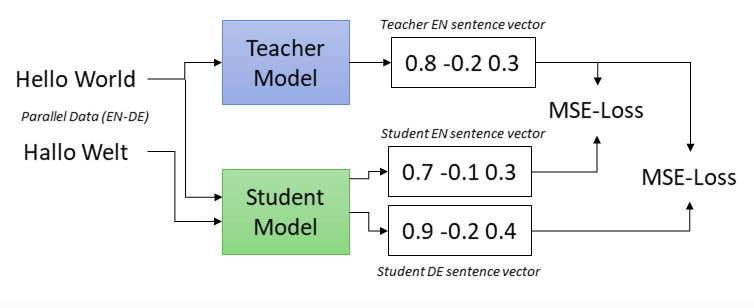

---

[Vorheriges Colab(Erstellung und Training des eigenen multilingualen Modells)](https://colab.research.google.com/drive/1hb-9B_D8eXfI7U8YCjC7xenMvu_TvUKh?hl=de#scrollTo=D37L7HrR4W3Z)

In [ ]:
!pip install -U sentence-transformers
!pip install ftfy regex tqdm
!pip install transformers sentencepiece -q
!pip install git+https://github.com/openai/CLIP.git
!pip install pytorch-lightning

!pip install kaggle
!pip install --upgrade --force-reinstall --no-deps kaggle

     |████████████████████████████████| 79 kB 6.9 MB/s 
     |████████████████████████████████| 4.0 MB 36.9 MB/s 
     |████████████████████████████████| 1.2 MB 52.5 MB/s 
     |████████████████████████████████| 77 kB 9.2 MB/s 
     |████████████████████████████████| 895 kB 66.2 MB/s 
     |████████████████████████████████| 6.6 MB 58.7 MB/s 
     |████████████████████████████████| 596 kB 61.4 MB/s 
  Created wheel for sentence-transformers: filename=sentence_transformers-2.2.0-py3-none-any.whl size=120747 sha256=3fcc14b506c0f66f41cc31f5f0481a659777ee734d86bc2cbc86b69883b78074
  Stored in directory: /root/.cache/pip/wheels/83/c0/df/b6873ab7aac3f2465aa9144b6b4c41c4391cfecc027c8b07e7
Successfully built sentence-transformers
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
     |████████████████████████████████| 53 kB 2.0 MB/s 
  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-bui

Setup

In [ ]:
#Models
from sentence_transformers import SentenceTransformer, util
from transformers import pipeline
import clip
import torch
import torch.nn.functional as F
from torch import nn
import pytorch_lightning as pl

#Transformer
from transformers import AutoTokenizer, AutoModel

#Images
from PIL import Image
import uuid
from urllib import request
from urllib.request import urlopen

#Basis
import os
from pathlib import Path
from tqdm.auto import tqdm
from google.colab import files
from typing import Dict, Tuple, List
import encodings

#Daten bearbeiten
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from tqdm.auto import tqdm

In [ ]:
class Config():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    batch_size = 64
    n_faktor = 20

    #TextEncoder
    text_encoder_model = "xlm-roberta-base"
    text_embedding = 768
    context_length = 77
    content_length_unicode = 60

    #Projection Head
    num_layer = 3
    dropout = 0.5
    projection_dim = 256

    clip_visual_model = 'RN50x4'
    clip_embed_dim = 640
    embedding_dim = 512

In [ ]:
uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
  
# Then move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 64 bytes


In [ ]:
!kaggle kernels output martenro/fork-of-preprocessedcaptionwikifeatherformat -p trainingdata
!kaggle kernels output martenro/fork-of-multiclipstep -p trainingdata
!kaggle kernels output martenro/multiclipstep -p trainingdata

Output file downloaded to trainingdata/test
Output file downloaded to trainingdata/test_caption_list
Output file downloaded to trainingdata/train-00000-of-00005
Output file downloaded to trainingdata/train-00001-of-00005
Output file downloaded to trainingdata/train-00002-of-00005
Output file downloaded to trainingdata/train-00003-of-00005
Output file downloaded to trainingdata/train-00004-of-00005
Output file downloaded to trainingdata/wiki_test.csv
Output file downloaded to trainingdata/wiki_test_caption_list.csv
Output file downloaded to trainingdata/wikidata.csv
Kernel log downloaded to trainingdata/fork-of-preprocessedcaptionwikifeatherformat.log 
tcmalloc: large alloc 1548656640 bytes == 0x725f4000 @  0x7fae622001e7 0x4a3940 0x5b438c 0x5b46f7 0x59afff 0x515655 0x59a257 0x570bf0 0x511ee1 0x549576 0x4bca8a 0x59c019 0x595ef6 0x5134a6 0x549576 0x4bca8a 0x59c019 0x595ef6 0x5134a6 0x549576 0x4bca8a 0x5134a6 0x549576 0x593fce 0x548ae9 0x51566f 0x549576 0x593fce 0x511e2c 0x549576 0x4bca8a

In [ ]:
#Erstellen der data und images Directory
Path('./trainingdata').mkdir(exist_ok=True)
Path('./images').mkdir(exist_ok=True)

In [ ]:
#Globals
DATASET_PATH = './'
D_NAME = 'https://upload.wikimedia.org'
IMAGE_DIR = './images/'
MODEL_PATH = './trainingdata/step45clip.ckpt'

Hilfsfunktionen

In [ ]:
def load_image(link):
    """
    Laden des Bildes aus dem übergebenen Link und Ausgabe als PIL Image
    """
    try:
        URL = link#.rsplit(';', 1)[1]
        filename = str(uuid.uuid4())
        path = f'./images/{filename}'
        req = request.Request(URL)
        req.add_header('User-Agent', 'User-bot-abc')#,'Connection', 'close')
        response = request.urlopen(req)
        
        with open(path, 'wb') as f:
            f.write(response.read())
        
        image = Image.open(path).convert("RGB")
        
        os.remove(path)
        
        return image
    
    except Exception as e:
        print(e)
        return ""

In [ ]:
#Quelle:
#https://stackoverflow.com/questions/13665001/python-truncating-international-string?lq=1

######
#Funktion zum Abschneiden der utf captions auf die CLIP Content Length
######
incr_encoder = encodings.search_function('utf8').incrementalencoder()

def utf8_byte_truncate(text, max_bytes):
    byte_len = 0
    incr_encoder.reset()
    for index,ch in enumerate(text):
        byte_len += len(incr_encoder.encode(ch))
        if byte_len > max_bytes:
            break
    else:
        return text
    return text[:index]

In [ ]:
df_wiki = pd.read_csv('./trainingdata/wikidata.csv')

In [ ]:
#Nur die wichtigen zwei columns behalten
df_wiki_lang = pd.DataFrame(df_wiki, columns = ['language', 'image_url','caption_title_and_reference_description'])

df_wiki_relevant = pd.DataFrame(df_wiki, columns = ['image_url','caption_title_and_reference_description'])
df_wiki_relevant

,image_url,caption_title_and_reference_description
0,https://upload.wikimedia.org/wikipedia/commons...,"Giày cao gót </s> Giày cao gót châu Âu, khoảng..."
1,https://upload.wikimedia.org/wikipedia/commons...,Grand Prix automobile de France 1957 </s> Juan...
2,https://upload.wikimedia.org/wikipedia/commons...,道谷站 </s> 車站月台
3,https://upload.wikimedia.org/wikipedia/commons...,北仙台站 </s> 月台
4,https://upload.wikimedia.org/wikipedia/commons...,Silver spoon </s> Two silver-gilt strainer spo...
...,...,...
11771,https://upload.wikimedia.org/wikipedia/commons...,Renault R23 </s> La Renault R23 de Jarno Trull...
11772,https://upload.wikimedia.org/wikipedia/commons...,Chanson des quatre fils Aymon </s> Vue des rui...
11773,https://upload.wikimedia.org/wikipedia/commons...,Дуньхуанская карта </s> Китайский Дуньхуанский...
11774,http://upload.wikimedia.org/wikipedia/commons/...,Géorgiques </s> Le jardin du vieillard corycie...


### Laden der Modelle

CLIP

In [ ]:
clip_model, preprocess = clip.load("ViT-B/32", device = Config.device)

100%|████████████████████████████████████████| 338M/338M [00:01<00:00, 182MiB/s]


Eigenes multilinguales Modell

In [ ]:
class Tokenizer:
    def __init__(self, tokenizer: AutoTokenizer):
        self.tokenizer = tokenizer

    def __call__(self, caption: str) -> AutoTokenizer:
        return self.tokenizer(
            caption,
            add_special_tokens = True,#<s> und </s> hinzufügen
            max_length = Config.context_length,
            truncation = True,
            padding = 'max_length',
            return_tensors = 'pt',
        )

    def decode(self, x: Dict[str, torch.LongTensor]):
        return [self.tokenizer.decode(sentence[:sentence_len]) for sentence, sentence_len in
                zip(x['input_ids'], x['attention_mask'].sum(axis=-1))]

In [ ]:
class ProjectionHead(nn.Module):
    ######
    #Beide Vektoren auf die gleiche Dimension bringen
    ######
    def __init__(self, dim_in, dim_out, p = Config.dropout):
        super().__init__()
        self.linear1 = nn.Linear(dim_in, dim_out, bias=False)
        self.linear2 = nn.Linear(dim_out, dim_out, bias=False)
        self.layer_norm = nn.LayerNorm(dim_out)
        self.drop = nn.Dropout(p)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        embed1 = self.linear1(x)
        embed2 = self.drop(self.linear2(F.gelu(embed1)))
        embeds = self.layer_norm(embed1 + embed2)
        return embeds

In [ ]:
class ImageEncoder(nn.Module):
    ######
    #Der ImageEncoder bleibt der vom CLIPModell
    ######
    def __init__(self, clip_vision_model, dim_in, dim_out):
        super().__init__()
        model = clip_vision_model
        self.model = model
        self.projection = ProjectionHead(dim_in, dim_out)
        for p in self.model.parameters():#backbone wird gefreezed
            p.requires_grad = False

    def forward(self, x):
        projected_vec = self.projection(self.model(x))
        projection_len = torch.norm(projected_vec, dim = -1, keepdim = True)
        return projected_vec / projection_len

In [ ]:
class TextEncoder(nn.Module):
    ######
    #Der TextEncoder wird mit dem multilingualen XlmRoberta-Transformer ersetzt
    ######
    def __init__(self, text_encoder_model, dim_out):
        super().__init__()
        self.model = AutoModel.from_pretrained(text_encoder_model)
        self.projection = ProjectionHead(Config.text_embedding, dim_out)
        for p in self.model.parameters():
            p.requires_grad = False
        
    def forward(self, x):
        out = self.model(**x)[0]
        out = out[:, 0, :] #</s> token
        projected_vec = self.projection(out)

        projection_len = torch.norm(projected_vec, dim = -1, keepdim = True)
        return projected_vec / projection_len

In [ ]:
class WikiCLIPMultilingual(pl.LightningModule):
    def __init__(self, 
                 clip_model,
                 transform_img,
                 tokenizer,
                 text_model_name,
                 clip_embed_dim = Config.clip_embed_dim,
                 embed_dim = Config.embedding_dim,
                ):
        super().__init__()
        self.clip_model = clip_model
        self.transform_img = transform_img
        self.tokenizer = tokenizer
        self.image_encoder = ImageEncoder(
            clip_model.visual,
            clip_embed_dim,
            embed_dim,
        )
        self.text_encoder = TextEncoder(text_model_name, embed_dim)
        self.save_hyperparameters()

In [ ]:
clip_model_multi, compose = clip.load(Config.clip_visual_model, device = Config.device)

100%|███████████████████████████████████████| 402M/402M [00:13<00:00, 30.3MiB/s]


In [ ]:
tokenizer = Tokenizer(AutoTokenizer.from_pretrained(Config.text_encoder_model))

multi_clip_45_epoch_model = WikiCLIPMultilingual.load_from_checkpoint(MODEL_PATH, clip_model = clip_model_multi, transform_img = compose, tokenizer = tokenizer, text_model_name = Config.text_encoder_model)
multi_clip_45_epoch_model.eval()

Downloading:   0%|          | 0.00/615 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/4.83M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/8.68M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.04G [00:00<?, ?B/s]

Some weights of the model checkpoint at xlm-roberta-base were not used when initializing XLMRobertaModel: ['lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializing XLMRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/utilities/parsing.py:262: UserWarning: Attribute 'clip_model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['clip_model'])`.
 

WikiCLIPMultilingual(
  (clip_model): CLIP(
    (visual): ModifiedResNet(
      (conv1): Conv2d(3, 40, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(40, 40, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(40, 80, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn3): BatchNorm2d(80, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (avgpool): AvgPool2d(kernel_size=2, stride=2, padding=0)
      (relu): ReLU(inplace=True)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(80, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(80, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(80, 80, kernel_s

In [ ]:
text_model_45 = multi_clip_45_epoch_model.text_encoder.to(Config.device)
image_model_45 = multi_clip_45_epoch_model.image_encoder.to(Config.device)

SentenceTransformer 'clip-ViT-B-32-multilingual-v1' 

In [ ]:
#image model
sentence_img_model = SentenceTransformer('clip-ViT-B-32')

#text model
sentence_text_model = SentenceTransformer('clip-ViT-B-32-multilingual-v1')

Downloading:   0%|          | 0.00/690 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/4.03k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/525k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/316 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/605M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/389 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/604 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/961k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.88k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/116 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/122 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/690 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/115 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.57M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/5.63k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/572 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/122 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/341 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/539M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/371 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/996k [00:00<?, ?B/s]

### Funktionen zur Erstellen der Bild- und Textembeddings

In [ ]:
def create_own_imgage_embeddings(img_list, image_model):
  num_batches = int(np.ceil(len(img_list) / Config.batch_size))
  image_embeds = []

  for idx in tqdm(range(num_batches)):
    start_idx = idx * Config.batch_size
    end_idx = start_idx + Config.batch_size
    current_image_urls = img_list[start_idx:end_idx]

    #Bilder für CLIP transformieren
    img_input = [compose(load_image(img)).unsqueeze(0).cuda() for img in current_image_urls]

    with torch.cuda.amp.autocast():#Automatic Mixed Precision package
          with torch.no_grad():
              for img in img_input:
                image_embeds.append(image_model(img.to(Config.device)))
    del img_input
    torch.cuda.empty_cache()
    image_embed = torch.cat(image_embeds)
  return image_embed

In [ ]:
#Gesamte image embeddings erstellen
def create_sentence_image_embeddings(image_urls, img_model):
    hits = 0
    num_batches = int(np.ceil(len(image_urls) / Config.batch_size))
    img_embed = []
    
    for idx in tqdm(range(num_batches)):
        start_idx = idx * Config.batch_size
        end_idx = start_idx + Config.batch_size
        current_image_urls = image_urls[start_idx:end_idx]
        
        with torch.no_grad():
            current_image_embed = img_model.encode([load_image(img) for img in current_image_urls], batch_size = Config.batch_size, convert_to_tensor = True, show_progress_bar = False).to(Config.device)
        
        img_embed.append(current_image_embed)
        del current_image_embed
        torch.cuda.empty_cache()
    img_embeds = torch.cat(img_embed)
    return img_embeds

In [ ]:
def create_image_embeddings(image_urls, model):
    hits = 0
    num_batches = int(np.ceil(len(image_urls) / Config.batch_size))
    img_embed = []
    
    for idx in tqdm(range(num_batches)):
        start_idx = idx * Config.batch_size
        end_idx = start_idx + Config.batch_size
        current_image_urls = image_urls[start_idx:end_idx]
        
        img_input = torch.stack([preprocess(load_image(img)).to(Config.device) for img in current_image_urls])
        
        with torch.no_grad():
            current_image_embed = model.encode_image(img_input.to(Config.device)).float()
        
        img_embed.append(current_image_embed)
        del img_input
        del current_image_embed
        torch.cuda.empty_cache()
    img_embeds = torch.cat(img_embed)
    return img_embeds

In [ ]:
def find_sentence_query_match(text_model, image_urls, img_emb, queries, n = 5):
    
    with torch.no_grad():
            cap_emb = text_model.encode([cap for cap in queries], convert_to_tensor = True, show_progress_bar = False).to(Config.device)
            
    image_embeddings_n = F.normalize(img_emb, p=2, dim=-1)
    text_embeddings_n = F.normalize(cap_emb, p=2, dim=-1)
    
    dot_similarity = text_embeddings_n @ image_embeddings_n.T
    
    values, indices = torch.topk(dot_similarity.squeeze(0), n, sorted = True)
    matches = [[image_urls[idx] for idx in results] for results in indices]
    return matches

In [ ]:
def find_own_query_match(text_model, image_url, img_emb, queries, n = 5):
    query_tok = tokenizer(queries)
    tokens = {k: v.to(Config.device) for k, v in query_tok.items()}
    
    with torch.no_grad():
            cap_emb = text_model(tokens)
            
    image_embeddings_n = F.normalize(img_emb, p=2, dim=-1)
    text_embeddings_n = F.normalize(cap_emb, p=2, dim=-1)
    
    dot_similarity = text_embeddings_n @ image_embeddings_n.T
    
    values, indices = torch.topk(dot_similarity.squeeze(0), n)
    matches = [[image_url[idx] for idx in results] for results in indices]

    return matches

In [ ]:
def find_query_match(model, image_urls, img_emb, queries, n = 5):
    query_tok = clip.tokenize(queries).to(Config.device)
    
    with torch.no_grad():
            cap_emb = model.encode_text(query_tok).float().to(Config.device)
            
    image_embeddings_n = F.normalize(img_emb, p=2, dim=-1)
    text_embeddings_n = F.normalize(cap_emb, p=2, dim=-1)
    
    dot_similarity = text_embeddings_n @ image_embeddings_n.T
    
    values, indices = torch.topk(dot_similarity.squeeze(0), n)
    
    matches = [[image_urls[idx] for idx in results] for results in indices]

    return matches

### Cosine Similarity am Beispiel der fünf häufigsten Sprachen

In [ ]:
def show_cosine_sim(img_list, languages, similarity): 
  count = len(img_list)

  plt.figure(figsize=(20, 14))
  plt.imshow(similarity, vmin=0.1, vmax=0.3)

  plt.yticks(range(count), languages, fontsize=18)
  plt.xticks([])
  for i, image in enumerate(img_list):
      plt.imshow(load_image(image), extent=(i - 0.5, i + 0.5, -1.6, -0.6), origin="lower")
  for x in range(similarity.shape[1]):
      for y in range(similarity.shape[0]):
          plt.text(x, y, f"{similarity[y, x]:.2f}", ha="center", va="center", size=12)

  for side in ["left", "top", "right", "bottom"]:
      plt.gca().spines[side].set_visible(False)

  plt.xlim([-0.5, count - 0.5])
  plt.ylim([count + 0.5, -2])

  plt.title("Cosine similarity zwischen Text und Bild features", size=20)

In [ ]:
def create_lang_list(data):
  #Die 5 häufigsten Sprachen testen
  lang_en_l = data[data.language == 'en'].iloc[0]
  lang_fr_l = data[data.language == 'fr'].iloc[0]
  lang_de_l = data[data.language == 'de'].iloc[0]
  lang_ceb_l = data[data.language == 'ceb'].iloc[0]
  lang_ja_l = data[data.language == 'ja'].iloc[0]

  lang_df = [lang_en_l, lang_fr_l, lang_de_l, lang_ceb_l, lang_ja_l]

  lang_dict = {}
  for lang in lang_df:
      lang_dict[lang['language']] = lang['caption_title_and_reference_description']
      
  img_list = []
  for img in lang_df:
      img_list.append(img['image_url'])
      
  cap_list = []
  for cap in lang_df:
      cap_list.append(cap['caption_title_and_reference_description'])
  return img_list, cap_list

In [ ]:
#Image embeddings erstellen
def create_own_test_emb(test_img_list, image_model):
  img_input_45_test = [multi_clip_45_epoch_model.transform_img(load_image(img)).unsqueeze(0).cuda() for img in test_img_list]
  image_embeds = []

  with torch.cuda.amp.autocast():#Automatic Mixed Precision package
      with torch.no_grad():
          for img in img_input_45_test:
              image_embeds.append(image_model(img.to(Config.device)))

  image_embed = torch.cat(image_embeds)
  return image_embed

In [ ]:
def create_own_test_txt_emd(cap_list, text_model):
  text_tokens = tokenizer([desc for desc in cap_list]).to(Config.device)
  with torch.no_grad():
      text_embd = text_model(text_tokens)
  return text_embd

In [ ]:
def create_sentence_test_emb(img_list, img_model):
  with torch.no_grad():
      img_emb = img_model.encode([load_image(img) for img in img_list], batch_size = Config.batch_size, convert_to_tensor = True, show_progress_bar = True).to(Config.device)
  return img_emb

In [ ]:
def create_sentence_test_txt_emd(cap_list, text_model):
  #Test Caption embedding
  with torch.no_grad():
      caption_emb = text_model.encode([cap for cap in cap_list], convert_to_tensor=True, show_progress_bar = False).to(Config.device)
  return caption_emb

In [ ]:
def crete_img_test_emb(img_list, clip_model):
  img_input_test = torch.stack([preprocess(load_image(img)).to(Config.device) for img in img_list])

  with torch.no_grad():
    image_embs_test = clip_model.encode_image(img_input_test.to(Config.device)).float()
  return image_embs_test

In [ ]:
def create_txt_test_emb(cap_list, clip_model):
  text_tokens = clip.tokenize([desc for desc in cap_list]).to(Config.device)

  with torch.no_grad():
    text_emb = clip_model.encode_text(text_tokens).float().to(Config.device)
  return text_emb

In [ ]:
#similarity berechnen
def create_similarity(image_embed, text_embd):
  image_embed /= image_embed.norm(dim=-1, keepdim=True)
  text_embd /= text_embd.norm(dim=-1, keepdim=True)
  similarity = text_embd.cpu().numpy() @ image_embed.cpu().numpy().T
  return similarity

In [ ]:
def truncate_nrm(cap_ref):
  for i, caption in enumerate(cap_ref):
      if len(caption) > Config.context_length:
          cap_ref[i] = caption[:Config.context_length]

def truncate_utf8(cap_ref):
  for i, caption in enumerate(cap_ref):
      if len(caption.encode('utf-8')) >= Config.content_length_unicode:
          cap_ref[i] = utf8_byte_truncate(caption, Config.content_length_unicode)

In [ ]:
def create_sim(img_emb, caption_emb):
  img_emb /= img_emb.norm(dim = -1, keepdim = True)
  caption_emb /= caption_emb.norm(dim = -1, keepdim = True)
  similarity = caption_emb.cpu().numpy() @ img_emb.cpu().numpy().T
  return similarity

In [ ]:
languages = ['en', 'fr', 'de', 'ceb', 'ja']

In [ ]:
img_list, cap_list = create_lang_list(df_wiki)

In [ ]:
#45-Modell embeddings
emb_45_img = create_own_test_emb(img_list, image_model_45)
emb_45_txt = create_own_test_txt_emd(cap_list, text_model_45)

In [ ]:
#sentence-Modell embedding
emb_sentence_img = create_sentence_test_emb(img_list, sentence_img_model)

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
emb_sentence_txt = create_sentence_test_txt_emd(cap_list, sentence_text_model)

In [ ]:
emb_clip_model_img = crete_img_test_emb(img_list, clip_model)

In [ ]:
emb_clip_model_txt = create_txt_test_emb(cap_list, clip_model)

Similarity

In [ ]:
sim_multi_45 = create_similarity(emb_45_img, emb_45_txt)

In [ ]:
sim_sentence = create_similarity(emb_sentence_img, emb_sentence_txt)

In [ ]:
sim_clip_model = create_similarity(emb_clip_model_img, emb_clip_model_txt)

Eigenes multilinguales Modell

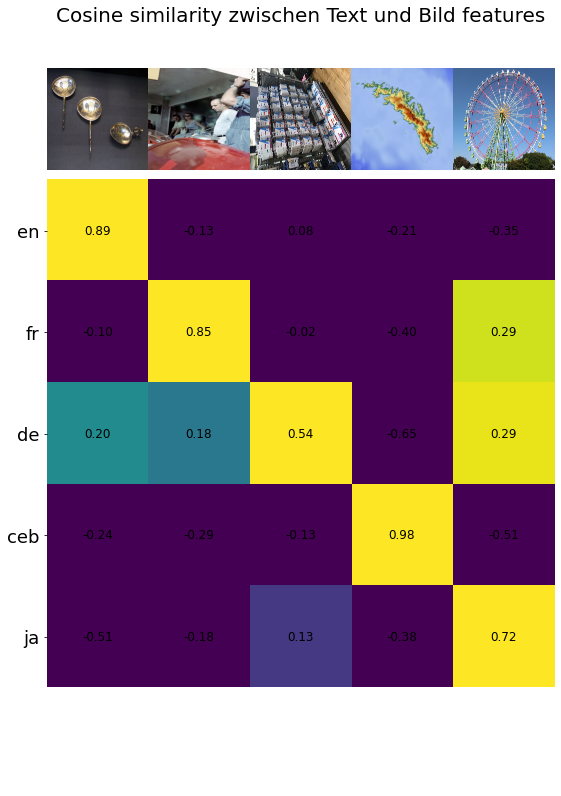

In [ ]:
show_cosine_sim(img_list, languages, sim_multi_45)

SentenceTransformer

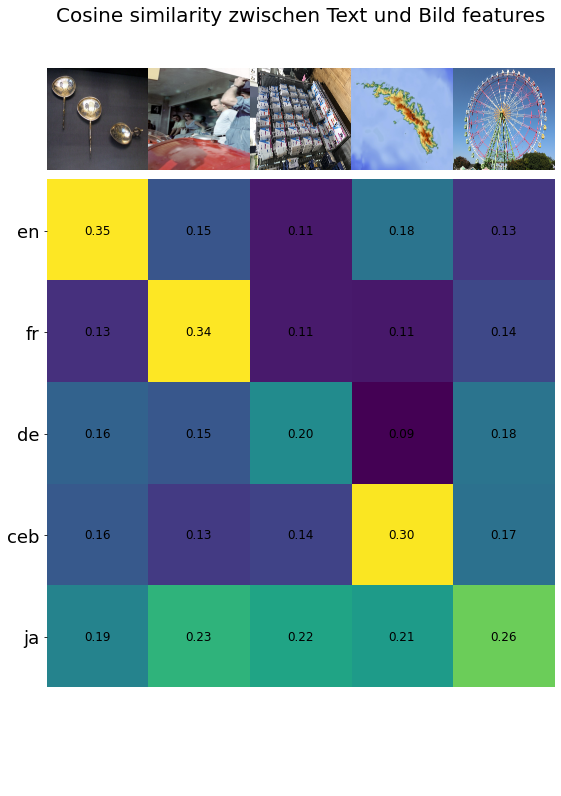

In [ ]:
show_cosine_sim(img_list, languages, sim_sentence)

CLIP

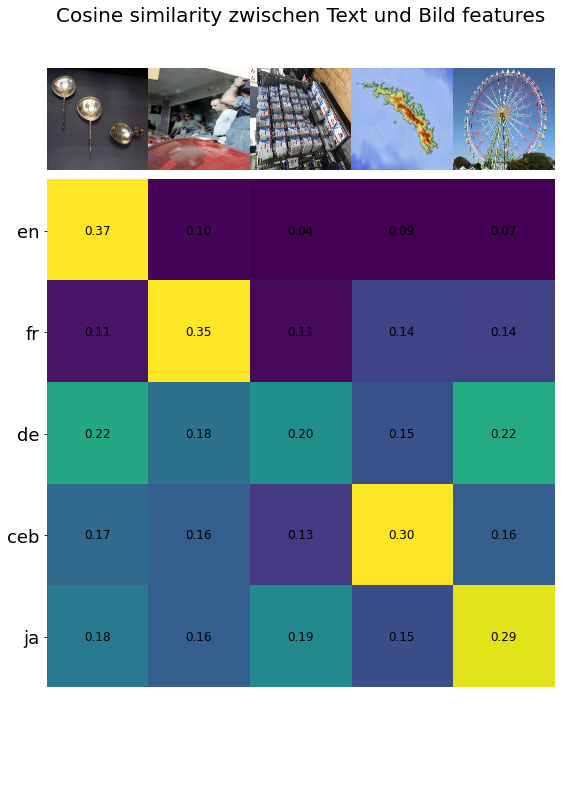

In [ ]:
show_cosine_sim(img_list, languages, sim_clip_model)

Zu sehen ist, dass das SentenceTransfromer Modell bei der Zero-Shot-Zuweisung alle Bilder sowie Texte richtig zuweist und somit besser abschneidet als das CLIP-Modell.

In [ ]:
df_wiki_rel_cap = df_wiki['caption_title_and_reference_description'].tolist()
df_wiki_rel_img = df_wiki['image_url'].tolist()

In [ ]:
eval_data = dict(zip(df_wiki_rel_img, df_wiki_rel_cap))

Embeddings für alle Bilder

In [ ]:
sentence_img_embeddings = create_sentence_image_embeddings(df_wiki_rel_img, sentence_img_model)

  0%|          | 0/184 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 4. 
  warnings.warn(str(msg))
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:2800: DecompressionBombWarning: Image size (105545760 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


In [ ]:
multi_45_embedding = create_own_imgage_embeddings(df_wiki_rel_img, image_model_45)

  0%|          | 0/184 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 4. 
  warnings.warn(str(msg))
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:2800: DecompressionBombWarning: Image size (105545760 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


In [ ]:
clip_model_embedding = create_image_embeddings(df_wiki_rel_img, clip_model)

  0%|          | 0/184 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 4. 
  warnings.warn(str(msg))
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:2800: DecompressionBombWarning: Image size (105545760 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


### Retrieval Vergleich

In [ ]:
def eval_sentence_topk_accuracy(image_urls, eval_data, img_embed, n = Config.n_faktor):
    hits = 0
    num_batches = int(np.ceil(len(image_urls) / Config.batch_size))
    
    for idx in tqdm(range(num_batches)):
        start_idx = idx * Config.batch_size
        end_idx = start_idx + Config.batch_size
        current_image_urls = image_urls[start_idx:end_idx]
        
        queries = [
            eval_data[url] for url in current_image_urls 
        ]
        result = find_sentence_query_match(sentence_text_model, image_urls, img_embed, queries, n)
        
        hits += sum(
            [
                url in matches
                for (url, matches) in list(zip(current_image_urls, result))
            ]
        )
        
    return hits / len(image_urls)

In [ ]:
print("Scoring sentence multilingual accuracy...")
accuracy = eval_sentence_topk_accuracy(df_wiki_rel_img, eval_data, sentence_img_embeddings)
print(f"CLIP accuracy: {round(accuracy * 100, 3)}%")

Scoring sentence multilingual accuracy...


  0%|          | 0/184 [00:00<?, ?it/s]

CLIP accuracy: 44.09%


In [ ]:
def eval_45_topk_accuracy(image_urls, eval_data, img_embed, n = Config.n_faktor):
    hits = 0
    num_batches = int(np.ceil(len(image_urls) / Config.batch_size))
    
    for idx in tqdm(range(num_batches)):
        start_idx = idx * Config.batch_size
        end_idx = start_idx + Config.batch_size
        current_image_urls = image_urls[start_idx:end_idx]
        
        queries = [
            eval_data[url] for url in current_image_urls 
        ]
        result = find_own_query_match(text_model_45, image_urls, img_embed, queries, n)
        
        hits += sum(
            [
                url in matches
                for (url, matches) in list(zip(current_image_urls, result))
            ]
        )
        
    return hits / len(image_urls)

In [ ]:
def eval_clip_topk_accuracy(image_urls, eval_data, img_embed, n = Config.n_faktor):
    hits = 0
    num_batche = int(np.ceil(len(image_urls) / Config.batch_size))
    
    for idx in tqdm(range(num_batches)):
        start_idx = idx * Config.batch_size
        end_idx = start_idx + Config.batch_size
        current_image_urls = image_urls[start_idx:end_idx]
        
        queries = [
            eval_data[url] for url in current_image_urls 
        ]
        result = find_query_match(clip_model, image_urls, img_embed, queries, n)
        
        hits += sum(
            [
                url in matches
                for (url, matches) in list(zip(current_image_urls, result))
            ]
        )
        
    return hits / len(image_urls)

In [ ]:
truncate_nrm(df_wiki_rel_cap)
truncate_utf8(df_wiki_rel_cap)
eval_data = dict(zip(df_wiki_rel_img, df_wiki_rel_cap))

In [ ]:
print("Scoring clip multilingual accuracy...")
accuracy = eval_clip_topk_accuracy(df_wiki_rel_img, eval_data, clip_model_embedding)
print(f"CLIP accuracy: {round(accuracy * 100, 1)}%")

Scoring clip multilingual accuracy...


  0%|          | 0/184 [00:00<?, ?it/s]

CLIP accuracy: 35.7%


Mit einer Verbesserung von fast 10 % gegenüber dem ZeroShot CLIP Modell schneidet das SetenceTransformer Modell mit einer Performanz von 44.09% am besten ab.

### Multilingual Prompt Engineering

Für das multilinguale Prompt Engineering wird vor dem übergeben der Captions an den Text Encoder ein Transfromer eingefügt, der per text2text-generation ein Übersetzen  Prompt an die Captions anfügt. Für das übersetzten der Prompt wurde der Transformer ['facebook/m2m100_418M'](https://huggingface.co/facebook/m2m100_418M) aus 'Beyond English-Centric Multilingual Machine Translation' Fan et al (2020) ausgewählt. M2M100 ist ein multilingualer  Encoder-Decoder, vortrainiert für Many-to-Many multilinguale übersetzung. 

Durch Zhou et al. (2022) in 'Learning to Prompt for Vision-Language Models' wurde gezeigt, dass zum Beispiel bei dem Datensatz Caltech101 das Hinzufügen von "a" vor der Klasse eine Verbesserung der Genauigkeit um 5 % ergab. Allerdings ist dies wiederum ein monolingualer Datensatz.

Deswegen werden im Folgenden einige Prompts auf ihre Auswirkung auf die Retrieval Performanz der Modelle untersucht.

In [ ]:
df_lang = df_wiki.language.drop_duplicates().tolist()

In [ ]:
print(df_lang[:10])
print(len(df_lang))

['vi', 'fr', 'zh-TW', 'en', 'fa', 'sv', 'de', 'it', 'hy', 'cs']
94


In [ ]:
#Creating a Text2TextGenerationPipeline for language translation
pipe = pipeline(task = 'text2text-generation', model = 'facebook/m2m100_418M')

Downloading:   0%|          | 0.00/908 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.80G [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/272 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/3.54M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.31M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.11k [00:00<?, ?B/s]

In [ ]:
def create_prompt(prompt):
  lang_promt = {}

  for idx, lang in enumerate(tqdm(df_lang)):
      try:
          prompts = pipe(prompt, forced_bos_token_id = pipe.tokenizer.get_lang_id(lang = lang))
          lang_prompt = prompts[0]
          lang_prompt[lang] = lang_prompt.pop('generated_text')
          lang_promt.update(lang_prompt)
      except Exception as e:
          print(e)
  return lang_promt

Als Prompts werden zunächste die Säzte "a photo of" und "From Wikipedia" in die entsprechenden Sprachen übersetzt. Nicht jede Sprache aus dem Datensatz wird von dem M2M100-Modell unterstütz und dementsprechend bleiben die ursprünglichen Captions erhalten.
Die nicht mit Prompts ausgestatteten Sprachen werden unten aufgeführt.

In [ ]:
lang_prompt_01 = create_prompt("a photo of")
lang_prompt_02 = create_prompt("From Wikipedia:")

  0%|          | 0/94 [00:00<?, ?it/s]

'zh-TW'
'eo'
'iw'
'eu'
'lah'
'sco'
'be-tarask'
'tg'
'te'
'nn'
'nds'
'ckb'
'sr-Latn'
'fil'
'bar'
'tt'
'ce'
'azb'
'la'
'yue'
'xmf'
'lmo'
'arz'


  0%|          | 0/94 [00:00<?, ?it/s]

'zh-TW'
'eo'
'iw'
'eu'
'lah'
'sco'
'be-tarask'
'tg'
'te'
'nn'
'nds'
'ckb'
'sr-Latn'
'fil'
'bar'
'tt'
'ce'
'azb'
'la'
'yue'
'xmf'
'lmo'
'arz'


In [ ]:
lang_caption = list(zip(df_wiki_lang.language, df_wiki_lang.caption_title_and_reference_description))

In [ ]:
lang_caption[:10]

[('vi', 'Giày cao gót </s> Giày cao gót châu Âu, khoảng 1690'),
 ('fr',
  'Grand Prix automobile de France 1957 </s> Juan Manuel Fangio et sa Maserati 250F\xa0: la combinaison à battre en 1957.'),
 ('zh-TW', '道谷站 </s> 車站月台'),
 ('zh-TW', '北仙台站 </s> 月台'),
 ('en',
  'Silver spoon </s> Two silver-gilt strainer spoons and a cignus spoon decorated with a mythical marine creature. (4th century AD Roman spoons from the Hoxne Hoard.)'),
 ('en',
  'List of New York State Historic Markers in Ulster County, New York </s> Historic marker for the house'),
 ('en',
  'San Pedro Carchá </s> Location of San Pedro Carchá in Franja Transversal del Norte'),
 ('fa', 'پاروی برف روبی </s> یک پیاده رو پاک شده با پارو.'),
 ('sv',
  'Three Brothers </s> Three Brothers i Sydgeorgien och Sydsandwichöarna (Storbritannien).'),
 ('fr', "Algyroides marchi </s> Répartition de l'espèce")]

In [ ]:
def check_lang(lang_id, lang_promt):
    back = False
    for lang_cap in lang_promt.items():
        if lang_id in lang_cap:
            back = True
            return back
    return back

In [ ]:
def get_prompt(lang_id, lang_promt):
    for lang_cap in lang_promt.items():
        if lang_id in lang_cap:
            return lang_cap[1]
    return ""

In [ ]:
print(get_prompt('vi', lang_prompt_01))
print(get_prompt('de', lang_prompt_02))

Một bức ảnh của
von Wikipedia:


In [ ]:
#Prompt und captions kombinieren
def combine_prompt_cap(lang_caption, lang_promt):
  df_caption_prompt = []

  for idx, row in enumerate(lang_caption):
      if check_lang(row[0], lang_promt):
          df_caption_prompt.append(get_prompt(row[0], lang_promt) + " " + row[1])
      else:
          df_caption_prompt.append(row[1])
  return df_caption_prompt

In [ ]:
df_caption_prompt_01 = combine_prompt_cap(lang_caption, lang_prompt_01)
df_caption_prompt_02 = combine_prompt_cap(lang_caption, lang_prompt_02)
print(df_caption_prompt_01[:10])
print(df_caption_prompt_02[:10])

['Một bức ảnh của Giày cao gót </s> Giày cao gót châu Âu, khoảng 1690', 'Une photo de Grand Prix automobile de France 1957 </s> Juan Manuel Fangio et sa Maserati 250F\xa0: la combinaison à battre en 1957.', '道谷站 </s> 車站月台', '北仙台站 </s> 月台', 'A photo of Silver spoon </s> Two silver-gilt strainer spoons and a cignus spoon decorated with a mythical marine creature. (4th century AD Roman spoons from the Hoxne Hoard.)', 'A photo of List of New York State Historic Markers in Ulster County, New York </s> Historic marker for the house', 'A photo of San Pedro Carchá </s> Location of San Pedro Carchá in Franja Transversal del Norte', 'یک عکس از پاروی برف روبی </s> یک پیاده رو پاک شده با پارو.', 'En bild av Three Brothers </s> Three Brothers i Sydgeorgien och Sydsandwichöarna (Storbritannien).', "Une photo de Algyroides marchi </s> Répartition de l'espèce"]
['Từ Wikipedia: Giày cao gót </s> Giày cao gót châu Âu, khoảng 1690', 'À partir de Wikipédia : Grand Prix automobile de France 1957 </s> Juan 

Wie zu sehen, wurden die Prompts in der jeweiligen Sprache vor den Captions eingefügt und können nun an die Text Encoder der Modelle übergeben werden.

In [ ]:
eval_data_prompt_01 = dict(zip(df_wiki_rel_img, df_caption_prompt_01))
eval_data_prompt_02 = dict(zip(df_wiki_rel_img, df_caption_prompt_02))

In [ ]:
print("Scoring sentence multilingual accuracy...")
accuracy = eval_sentence_topk_accuracy(df_wiki_rel_img, eval_data_prompt_01, sentence_img_embeddings)
print(f"CLIP accuracy: {round(accuracy * 100, 3)}%")

Scoring sentence multilingual accuracy...


  0%|          | 0/184 [00:00<?, ?it/s]

CLIP accuracy: 42.994%


In [ ]:
print("Scoring sentence multilingual accuracy...")
accuracy = eval_sentence_topk_accuracy(df_wiki_rel_img, eval_data_prompt_02, sentence_img_embeddings)
print(f"CLIP accuracy: {round(accuracy * 100, 3)}%")

Scoring sentence multilingual accuracy...


  0%|          | 0/184 [00:00<?, ?it/s]

CLIP accuracy: 38.91%


In [ ]:
print("Scoring 25-Epoch model multilingual accuracy...")
accuracy = eval_45_topk_accuracy(df_wiki_rel_img, eval_data_prompt_01, multi_45_embedding)
print(f"CLIP accuracy: {round(accuracy * 100, 3)}%")

Scoring 25-Epoch model multilingual accuracy...


  0%|          | 0/184 [00:00<?, ?it/s]

CLIP accuracy: 15.914%


In [ ]:
print("Scoring 25-Epoch model multilingual accuracy...")
accuracy = eval_45_topk_accuracy(df_wiki_rel_img, eval_data_prompt_02, multi_45_embedding)
print(f"CLIP accuracy: {round(accuracy * 100, 3)}%")

Scoring 25-Epoch model multilingual accuracy...


  0%|          | 0/184 [00:00<?, ?it/s]

CLIP accuracy: 15.336%


In [ ]:
truncate_nrm(df_caption_prompt_01)
truncate_utf8(df_caption_prompt_01)
truncate_nrm(df_caption_prompt_02)
truncate_utf8(df_caption_prompt_02)
eval_data_prompt_01 = dict(zip(df_wiki_rel_img, df_caption_prompt_01))
eval_data_prompt_02 = dict(zip(df_wiki_rel_img, df_caption_prompt_02))

In [ ]:
print("Scoring clip multilingual accuracy...")
accuracy = eval_clip_topk_accuracy(df_wiki_rel_img, eval_data_prompt_01, clip_model_embedding)
print(f"CLIP accuracy: {round(accuracy * 100, 1)}%")

Scoring clip multilingual accuracy...


  0%|          | 0/184 [00:00<?, ?it/s]

CLIP accuracy: 29.4%


In [ ]:
print("Scoring clip multilingual accuracy...")
accuracy = eval_clip_topk_accuracy(df_wiki_rel_img, eval_data_prompt_02, clip_model_embedding)
print(f"CLIP accuracy: {round(accuracy * 100, 1)}%")

Scoring clip multilingual accuracy...


  0%|          | 0/184 [00:00<?, ?it/s]

CLIP accuracy: 25.0%


Durch keines der multilingualen Prompts konnte eine Verbesserung der Retrieval Performanz erreicht werden.

## Fazit und Ausblick

Der Vergleich des englischen Retrieval mit 78.89% zum multilingualen Retrieval mit 35.7% durch Zero Shot CLIP hat gezeigt, dass es für die Bearbeitung der Wikipedia -Image/Caption Matching Competition andere Lösungen braucht. 
Nach dem Erstellen und Trainieren eines eigenen multilingualen Modells wurde gezeigt, dass die Performanz bis zum derzeitigen Stand von 45 trainierten Epochen ansteigt. Allerdings ist das Retrievalergebniss noch unter dem des monolingualen CLIP-Modells.

In diesem Notebook wurden nun zwei weitere Lösungsansätze zur Bearbeitung der Competition gezeigt. Mit dem SentenceTransformer-Modell wurde eine Steigerung der Performanz um rund 10 % erreicht. Das Prompt Engineering hat jedoch zu keinerlei Verbesserung geführt.

Als nächstes wäre es denkbar, einerseits das eigene Modell weiter zu trainieren und andererseits dass SentenceTransformer-Modell ähnlich dem eigenen Modell finezutunen/zu traineren.

Eine weitere Möglichkeit wäre als Ensemblemethoden das eigene multilinguale Modell und das SentenceTransformer-Modell zu stacken.